In [1]:
import pyspark as ps
import pyspark.sql.functions as f
from pyspark import SQLContext
from pyspark.sql.types import IntegerType, DateType, TimestampType
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[4] appName=sparkSQL exercise>

In [4]:
sqlContext = SQLContext(sc)

In [ ]:
df = sqlContext.read.csv("uk100.csv", header=True)

In [ ]:
df.printSchema()

In [ ]:
df.createOrReplaceTempView('test')

In [ ]:
spark.sql('''SELECT *
            FROM test
            LIMIT 30
            ''').show()

## Drop unneeded columns and cast the rest to the correct types.

In [9]:
df = df.drop('_c0')
df = df.drop('hmm')

for col in df.columns:
    df = df.withColumn(col, f.lower(f.col(col)))

df = df.withColumn("rank", df["rank"].cast(IntegerType()))
df = df.withColumn("peak_rank", df["peak_rank"].cast(IntegerType()))
df = df.withColumn("weeks_on_chart", df["weeks_on_chart"].cast(IntegerType()))

def to_date(x):
    return datetime.strptime(x, '%B %d %Y')
change_to_datetype = f.udf(lambda y: to_date(y), DateType())

df = df.withColumn("week_of", change_to_datetype('week_of'))

In [10]:
df.printSchema()

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



In [11]:
df.createOrReplaceTempView('test')

## Total Count

In [12]:
spark.sql('''
        SELECT COUNT(*)
        FROM test
        ''').show()

+--------+
|count(1)|
+--------+
|   26000|
+--------+



In [13]:
spark.sql('''
        SELECT *
        FROM test
        ''').show()

+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|rank|last_week_rank|               title|              artist|               label|peak_rank|weeks_on_chart|   week_of|
+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|   1|            11|               river|      ellie goulding|             polydor|        1|             5|2019-12-27|
|   2|             8|all i want for ch...|        mariah carey|            columbia|        2|            99|2019-12-27|
|   3|             5|      last christmas|                wham|                 rca|        2|            64|2019-12-27|
|   4|            14|fairytale of new ...|pogues ft kirsty ...|         warner bros|        2|            99|2019-12-27|
|   5|             2|              own it|stormzy/ed sheera...|      atlantic/merky|        2|             5|2019-12-27|
|   6|            16|merry chris

## Count of distinct titles (songs with same names included)

In [14]:
spark.sql('''
        SELECT COUNT(DISTINCT title)
        FROM test
        ''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                 2416|
+---------------------+



## Number of distinct titles that have reached rank 1

In [15]:
spark.sql('''
        SELECT COUNT(DISTINCT title)
        FROM test
        WHERE rank == 1''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   77|
+---------------------+



## Number of unique songs

In [16]:
num_unique_songs = spark.sql('''
        SELECT artist, title
        FROM test
        GROUP BY artist, title''')

In [17]:
num_unique_songs.count()

2605

In [18]:
spark.sql('''
        SELECT COUNT(*)
        FROM(
            SELECT artist, title
            FROM test
            GROUP BY artist, title)
        ''').show()

+--------+
|count(1)|
+--------+
|    2605|
+--------+



## How many weeks did these songs stay at rank 1

In [19]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE rank == 1
            GROUP BY 1, 2
            ORDER BY 3 DESC
            ''').show()

+--------------------+--------------------+---------+------------+
|              artist|               title|num_weeks|min(week_of)|
+--------------------+--------------------+---------+------------+
|drake ft wizkid &...|           one dance|       15|  2016-04-15|
|          ed sheeran|        shape of you|       14|  2017-01-13|
|luis fonsi/daddy ...|   despacito (remix)|       11|  2017-05-12|
|           tones & i|        dance monkey|       11|  2019-10-04|
|               drake|          god's plan|        9|  2018-01-26|
|        clean bandit|            rockabye|        9|  2016-11-11|
|ed sheeran & just...|        i don't care|        8|  2019-05-17|
|calvin harris & d...|            one kiss|        8|  2018-04-20|
|       lewis capaldi|   someone you loved|        7|  2019-03-01|
|calvin harris & s...|            promises|        6|  2018-09-07|
|          ed sheeran|             perfect|        6|  2017-12-08|
|shawn mendes/cami...|            senorita|        6|  2019-07

## Total number of appearances on the top 100 tht peaked at rank 1, in order

In [21]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE peak_rank == 1
            GROUP BY 1,2
            ORDER BY 3 DESC
            ''').show()

+--------------------+-------------------+---------+------------+
|              artist|              title|num_weeks|min(week_of)|
+--------------------+-------------------+---------+------------+
|          ed sheeran|       shape of you|       97|  2017-01-13|
|          ed sheeran|  thinking out loud|       90|  2015-01-11|
|          ed sheeran|            perfect|       81|  2017-12-08|
|         george ezra|            shotgun|       74|  2018-06-29|
|mark ronson ft br...|        uptown funk|       72|  2015-01-11|
|luis fonsi/daddy ...|  despacito (remix)|       71|  2017-05-12|
|       justin bieber|              sorry|       65|  2015-11-20|
|drake ft wizkid &...|          one dance|       64|  2016-04-15|
|       justin bieber|      love yourself|       62|  2015-12-04|
|       justin bieber|   what do you mean|       62|  2015-09-04|
|            dua lipa|          new rules|       61|  2017-08-18|
|       years & years|               king|       59|  2015-03-08|
|      ell

## Average number of weeks in the top 100 (songs that hit rank 1)

In [22]:
spark.sql('''
            SELECT AVG(num_weeks)
            FROM (SELECT DISTINCT title, COUNT(*) as num_weeks, MIN(week_of)
                    FROM test
                    WHERE peak_rank == 1
                    GROUP BY 1
                    ORDER BY 2 DESC)
            ''').show()

+------------------+
|    avg(num_weeks)|
+------------------+
|26.708661417322833|
+------------------+



## Average rank for the song "Shape of You" by Ed Sheeran

In [23]:
spark.sql('''
            SELECT ROUND(AVG(rank),2), MAX(weeks_on_chart)
            FROM test
            WHERE title = "shape of you"
            ''').show()

+-----------------------------------+-------------------+
|round(avg(CAST(rank AS BIGINT)), 2)|max(weeks_on_chart)|
+-----------------------------------+-------------------+
|                              42.52|                 97|
+-----------------------------------+-------------------+



## Average rank and number of weeks on chart per song

In [27]:
spark.sql('''
            SELECT artist, title, AVG(rank), COUNT(*)
            FROM test
            GROUP BY artist, title''').show()

+--------------------+--------------------+------------------+--------+
|              artist|               title|         avg(rank)|count(1)|
+--------------------+--------------------+------------------+--------+
|          elton john| step into christmas|  38.8421052631579|      19|
|clean bandit ft e...|                mama|              98.0|       1|
|            m o/chip|           wondering|              91.0|       1|
|               drake|             nonstop| 40.84615384615385|      13|
|florence & the ma...|             big god|              97.0|       1|
|raye/mabel/steffl...|           cigarette|              55.5|      16|
|   jax jones ft raye|   you don't know me| 36.24242424242424|      33|
|ryan gosling & em...|       city of stars|             68.25|       4|
|kygo ft ella hend...|        here for you|              52.0|      10|
|sigma ft paloma f...|            changing| 65.22222222222223|      18|
|        adam lambert|          ghost town|              76.5|  

## Create new db of new songs only

In [38]:
new_songs = spark.sql('''
            SELECT artist, title
            FROM test
            WHERE last_week_rank like "%new%"''')

In [36]:
spark.sql('''
            SELECT COUNT(*)
            FROM (SELECT artist, title
                    FROM test
                    WHERE last_week_rank like "%new%")''').show()

+--------+
|count(1)|
+--------+
|    2340|
+--------+



## Left semi join to remove non-new songs from original db

In [44]:
new_songs_2015_2019 = df.join(new_songs, ['title', 'artist'],how='leftsemi')

In [45]:
new_songs_2015_2019.createOrReplaceTempView('test2')

In [78]:
spark.sql('''
            SELECT *
            FROM test2''').show()

+--------------------+--------------------+----+--------------+--------------------+---------+--------------+----------+
|               title|              artist|rank|last_week_rank|               label|peak_rank|weeks_on_chart|   week_of|
+--------------------+--------------------+----+--------------+--------------------+---------+--------------+----------+
|               river|      ellie goulding|   1|            11|             polydor|        1|             5|2019-12-27|
|              own it|stormzy/ed sheera...|   5|             2|      atlantic/merky|        2|             5|2019-12-27|
|happy christmas (...|         john legend|   9|            34|            columbia|        9|             3|2019-12-27|
|       before you go|       lewis capaldi|  12|             3|                 emi|        2|             6|2019-12-27|
|     don't start now|            dua lipa|  14|             4|      warner records|        2|             8|2019-12-27|
|             roxanne|      ariz

In [47]:
spark.sql('''
            SELECT COUNT(*)
            FROM test2''').show()

+--------+
|count(1)|
+--------+
|   22822|
+--------+



In [51]:
spark.sql('''
            SELECT artist, title
            FROM test2
            GROUP BY artist, title''').show()

+--------------------+--------------------+
|              artist|               title|
+--------------------+--------------------+
|clean bandit ft e...|                mama|
|            m o/chip|           wondering|
|               drake|             nonstop|
|florence & the ma...|             big god|
|raye/mabel/steffl...|           cigarette|
|   jax jones ft raye|   you don't know me|
|ryan gosling & em...|       city of stars|
|kygo ft ella hend...|        here for you|
|        adam lambert|          ghost town|
|               ciara|               i bet|
|charli xcx ft rit...|            doing it|
|       bars & melody|        keep smiling|
|beyonce/glover/ei...|can you feel the ...|
|clean bandit ft d...|                solo|
|        shawn mendes|where were you in...|
|               drake| diplomatic immunity|
|        lil uzi vert|       xo tour llif3|
|teddy mac the son...|you make me feel ...|
|          little mix|                hair|
|           aronchupa|    i'm an

In [52]:
spark.sql('''
            SELECT COUNT(*)
            FROM (SELECT artist, title
                FROM test2
                GROUP BY artist, title)''').show()

+--------+
|count(1)|
+--------+
|    2339|
+--------+



In [54]:
new_songs_2015_2019.printSchema()

root
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



In [55]:
spark.sql('''
            SELECT COUNT(*)
            FROM test2''').show()

+--------+
|count(1)|
+--------+
|   22822|
+--------+



## number of appearances per song and avg rank

In [56]:
spark.sql('''
            SELECT title, artist, count(*), ROUND(AVG(rank),2), MIN(week_of) as week_entered
            FROM test2
            GROUP BY title, artist
            ORDER BY 3 DESC''').show()

+--------------------+--------------------+--------+-----------------------------------+------------+
|               title|              artist|count(1)|round(avg(CAST(rank AS BIGINT)), 2)|week_entered|
+--------------------+--------------------+--------+-----------------------------------+------------+
|             perfect|          ed sheeran|     110|                              48.09|  2017-03-10|
|        shape of you|          ed sheeran|      97|                              42.52|  2017-01-13|
|             shotgun|         george ezra|      87|                              35.99|  2018-03-30|
|             lean on|major lazer ft mo...|      79|                              45.92|  2015-03-08|
|          this is me|settle/greatest s...|      75|                              40.84|  2018-01-05|
|     shut up & dance|       walk the moon|      72|                              54.63|  2015-06-07|
|can't stop the fe...|   justin timberlake|      71|                              

In [63]:
spark.sql('''
            SELECT AVG(count)
            FROM (SELECT title, artist, COUNT(*) as count
                FROM test2
                GROUP BY 1,2
                HAVING count >4
                ORDER BY 3)
            ''').show()

+------------------+
|        avg(count)|
+------------------+
|17.502525252525253|
+------------------+



## Number of appearances by label

In [64]:
spark.sql('''
            SELECT label, COUNT(*)
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+--------+
|               label|count(1)|
+--------------------+--------+
|            atlantic|    1956|
|          interscope|    1433|
|            columbia|    1312|
|             polydor|    1137|
|                 rca|     991|
|    republic records|     773|
|          syco music|     731|
|                 emi|     721|
|              virgin|     719|
|          parlophone|     650|
|              asylum|     650|
|cash money/republ...|     644|
|              island|     590|
|         warner bros|     553|
|             def jam|     485|
|             capitol|     480|
|   ministry of sound|     425|
|            positiva|     364|
|                epic|     361|
|          relentless|     360|
+--------------------+--------+
only showing top 20 rows



In [67]:
spark.sql('''
            SELECT COUNT(DISTINCT label)
            FROM test2
            ''').show()

+---------------------+
|count(DISTINCT label)|
+---------------------+
|                  376|
+---------------------+



## Average rank of each label

In [68]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+---------+--------+
|               label|num_songs|avg_rank|
+--------------------+---------+--------+
|          interscope|      164|    50.1|
|            atlantic|      123|   46.35|
|                 rca|      120|   53.58|
|            columbia|      118|   47.42|
|              virgin|      107|   53.34|
|             polydor|      104|   49.25|
|              island|       81|   52.89|
|cash money/republ...|       76|   50.05|
|          syco music|       72|   45.64|
|                 emi|       66|   46.21|
|             def jam|       64|   53.74|
|          parlophone|       63|    49.7|
|    republic records|       54|   43.32|
|         warner bros|       46|   47.68|
|             capitol|       42|   46.08|
|              asylum|       34|   44.89|
|   ministry of sound|       33|   45.56|
| republic records/xo|       32|   47.05|
|                epic|       32|   53.89|
|          relentless|       26|   54.46|
+--------------------+---------+--

In [69]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            HAVING num_songs >15
            ORDER BY 3
            ''').show(50, False)

+---------------------------+---------+--------+
|label                      |num_songs|avg_rank|
+---------------------------+---------+--------+
|republic records           |54       |43.32   |
|positiva                   |21       |43.67   |
|asylum                     |34       |44.89   |
|merky                      |16       |45.04   |
|ministry of sound          |33       |45.56   |
|syco music                 |72       |45.64   |
|capitol                    |42       |46.08   |
|emi                        |66       |46.21   |
|atlantic                   |123      |46.35   |
|warner records             |16       |46.38   |
|republic records/xo        |32       |47.05   |
|disruptor                  |16       |47.25   |
|columbia                   |118      |47.42   |
|warner bros                |46       |47.68   |
|polydor                    |104      |49.25   |
|parlophone                 |63       |49.7    |
|cash money/republic records|76       |50.05   |
|interscope         

## Average rank per label (without collabs)

In [70]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title), ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            WHERE label NOT IN (SELECT label
                                FROM test2
                                WHERE label like "%/%"
                                GROUP BY label)
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(20, False)

+-----------------+---------------------+--------+
|label            |count(DISTINCT title)|avg_rank|
+-----------------+---------------------+--------+
|interscope       |164                  |50.1    |
|atlantic         |123                  |46.35   |
|rca              |120                  |53.58   |
|columbia         |118                  |47.42   |
|virgin           |107                  |53.34   |
|polydor          |104                  |49.25   |
|island           |81                   |52.89   |
|syco music       |72                   |45.64   |
|emi              |66                   |46.21   |
|def jam          |64                   |53.74   |
|parlophone       |63                   |49.7    |
|republic records |54                   |43.32   |
|warner bros      |46                   |47.68   |
|capitol          |42                   |46.08   |
|asylum           |34                   |44.89   |
|ministry of sound|33                   |45.56   |
|epic             |32          

## Most appearances by artist

In [73]:
spark.sql('''
            SELECT DISTINCT artist, COUNT(*), ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC''').show()

+--------------+--------+--------+
|        artist|count(1)|avg_rank|
+--------------+--------+--------+
|    ed sheeran|     440|   45.51|
|         drake|     352|    49.4|
| justin bieber|     265|   46.88|
| ariana grande|     254|   39.24|
|    little mix|     244|   45.81|
|  shawn mendes|     213|   42.92|
|   jess glynne|     207|   44.33|
|   george ezra|     194|   45.12|
|        weeknd|     187|   45.75|
|      dua lipa|     172|   41.03|
| lewis capaldi|     158|   29.18|
| years & years|     157|   45.59|
|       stormzy|     142|    49.3|
|  zara larsson|     142|   43.61|
|ellie goulding|     140|    44.9|
|   post malone|     137|   45.58|
|  taylor swift|     131|   50.73|
|    anne-marie|     127|   45.94|
|      coldplay|     122|   48.21|
|           sia|     121|   52.83|
+--------------+--------+--------+
only showing top 20 rows



## More Ed Sheeran

In [74]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test2
            WHERE artist = "ed sheeran"
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(30, False)

+------------------------------+--------+----+------------+
|title                         |count(1)|peak|min(week_of)|
+------------------------------+--------+----+------------+
|perfect                       |110     |1   |2017-03-10  |
|shape of you                  |97      |1   |2017-01-13  |
|castle on the hill            |53      |2   |2017-01-13  |
|galway girl                   |31      |2   |2017-03-10  |
|supermarket flowers           |21      |8   |2017-03-10  |
|happier                       |18      |6   |2017-03-10  |
|what do i know                |17      |9   |2017-03-10  |
|new man                       |14      |5   |2017-03-10  |
|dive                          |13      |8   |2017-03-10  |
|barcelona                     |13      |12  |2017-03-10  |
|how would you feel (paean)    |12      |2   |2017-02-24  |
|nancy mulligan                |10      |13  |2017-03-10  |
|hearts don't break around here|8       |15  |2017-03-10  |
|eraser                        |8       

In [75]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test2
            WHERE artist = "ed sheeran"
            GROUP BY 1
            HAVING peak < 6
            ORDER BY 2 DESC
            ''').show(20, False)

+--------------------------+--------+----+------------+
|title                     |count(1)|peak|min(week_of)|
+--------------------------+--------+----+------------+
|perfect                   |110     |1   |2017-03-10  |
|shape of you              |97      |1   |2017-01-13  |
|castle on the hill        |53      |2   |2017-01-13  |
|galway girl               |31      |2   |2017-03-10  |
|new man                   |14      |5   |2017-03-10  |
|how would you feel (paean)|12      |2   |2017-02-24  |
+--------------------------+--------+----+------------+



In [76]:
spark.sql('''
            SELECT COUNT(DISTINCT title)
            FROM test2
            WHERE artist = "ed sheeran"
            
            ''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   17|
+---------------------+



In [77]:
df.printSchema() #table = test
new_songs_2015_2019.printSchema() # table = test2

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)

root
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



## Life of songs (ordered by first entrance date) with avg rank over life

In [80]:
spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test2
            GROUP BY 1,2
            ORDER BY 5''').show()

+--------------------+--------------------+---------+--------+-------------+
|              artist|               title|num_weeks|avg_rank|entrance_date|
+--------------------+--------------------+---------+--------+-------------+
|kygo ft conrad se...|           firestone|       55|   46.56|   2015-01-11|
|                 omi|         cheerleader|       16|   60.81|   2015-01-11|
|           james bay|               scars|        9|   76.89|   2015-01-11|
|        fall out boy|        irresistible|        2|    75.5|   2015-01-11|
|tchami ft kaleem ...|           promesses|        9|   43.33|   2015-01-11|
|fuse odg ft killb...|    thinking about u|        3|   80.67|   2015-01-11|
|              tulisa|  living without you|        1|    44.0|   2015-01-11|
|noel gallagher's ...|ballad of the mig...|        4|   67.25|   2015-01-18|
|        all time low|something's gotta...|        1|    84.0|   2015-01-18|
|        fall out boy|         uma thurman|        3|    83.0|   2015-01-18|

## starting rank

In [93]:
spark.sql('''
            SELECT artist, title, rank, week_of
            FROM test2
            WHERE weeks_on_chart = 1
            ORDER BY 4''').show()

+--------------------+--------------------+----+----------+
|              artist|               title|rank|   week_of|
+--------------------+--------------------+----+----------+
|                 omi|         cheerleader|  96|2015-01-11|
|           james bay|               scars|  63|2015-01-11|
|kygo ft conrad se...|           firestone|  97|2015-01-11|
|        fall out boy|        irresistible|  70|2015-01-11|
|tchami ft kaleem ...|           promesses|   7|2015-01-11|
|              tulisa|  living without you|  44|2015-01-11|
|fuse odg ft killb...|    thinking about u|  79|2015-01-11|
|        fall out boy|         uma thurman|  71|2015-01-18|
|noel gallagher's ...|ballad of the mig...|  75|2015-01-18|
|        all time low|something's gotta...|  84|2015-01-18|
|             prodigy|               nasty|  98|2015-01-18|
|        fall out boy|american beauty/a...|  89|2015-01-18|
|          rae morris|   under the shadows|  53|2015-01-18|
|    big sean ft e-40|i don't f**k with.

In [110]:
join1 = spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test2
            GROUP BY 1,2
            ORDER BY 5''')

In [111]:
join2 = spark.sql('''
            SELECT artist, title, rank, week_of as entrance_date
            FROM test2
            WHERE weeks_on_chart = 1
            ORDER BY 4''')

## Join for final df???

In [116]:
left_join = join1.join(join2, ['title', 'artist', 'entrance_date'],how='left')

In [117]:
left_join.createOrReplaceTempView('test3')

In [118]:
spark.sql('''
            SELECT COUNT(*)
            FROM test3''').show()

+--------+
|count(1)|
+--------+
|    2339|
+--------+



In [120]:
spark.sql('''
            SELECT *
            FROM test3
            ORDER BY num_weeks DESC''').show()

+--------------------+--------------------+-------------+---------+--------+----+
|               title|              artist|entrance_date|num_weeks|avg_rank|rank|
+--------------------+--------------------+-------------+---------+--------+----+
|             perfect|          ed sheeran|   2017-03-10|      110|   48.09|   4|
|        shape of you|          ed sheeran|   2017-01-13|       97|   42.52|   1|
|             shotgun|         george ezra|   2018-03-30|       87|   35.99|  35|
|             lean on|major lazer ft mo...|   2015-03-08|       79|   45.92|  77|
|          this is me|settle/greatest s...|   2018-01-05|       75|   40.84|  28|
|     shut up & dance|       walk the moon|   2015-06-07|       72|   54.63|  75|
|can't stop the fe...|   justin timberlake|   2016-05-13|       71|   46.94|   3|
|               sorry|       justin bieber|   2015-10-30|       68|   41.43|   2|
|            stitches|        shawn mendes|   2015-09-25|       67|   47.63|  97|
|           new 

In [184]:
num_per_month_test = spark.sql('''
            SELECT MONTH(entrance_date) as month, COUNT(*) as count
            FROM test3
            GROUP BY MONTH(entrance_date)
            ORDER BY 1
            ''').collect()

In [185]:
num_per_month_test

[Row(month=1, count=143),
 Row(month=2, count=177),
 Row(month=3, count=249),
 Row(month=4, count=201),
 Row(month=5, count=241),
 Row(month=6, count=193),
 Row(month=7, count=168),
 Row(month=8, count=182),
 Row(month=9, count=215),
 Row(month=10, count=190),
 Row(month=11, count=243),
 Row(month=12, count=137)]

In [187]:
num_songs_per_month = []
for idx, v in enumerate(num_per_month_test):
    num_songs_per_month.append(v[1])

In [188]:
num_songs_per_month

[143, 177, 249, 201, 241, 193, 168, 182, 215, 190, 243, 137]

In [189]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

Text(0.5, 1.0, 'Number of Songs Per Month')

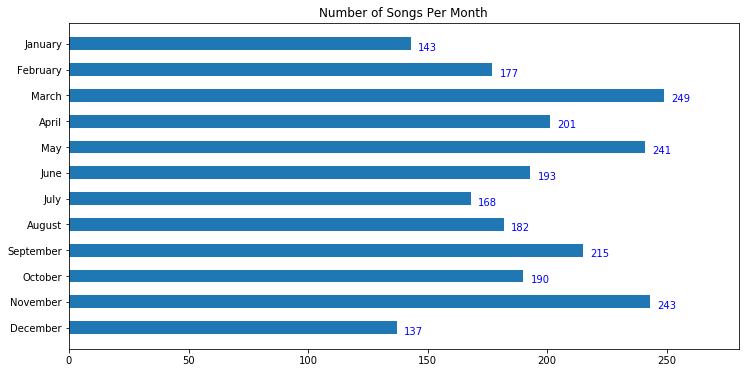

In [190]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, num_songs_per_month, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(num_songs_per_month):
    ax.text(v + 3, i + .25, str(v), color='blue')
ax.set_xlim(0,280)
ax.set_title('Number of Songs Per Month')

In [193]:
spark.sql('''
            SELECT MONTH(entrance_date), ROUND(AVG(num_weeks),2)
            FROM test3
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''').show()

+--------------------+------------------------+
|month(entrance_date)|round(avg(num_weeks), 2)|
+--------------------+------------------------+
|                   1|                   14.31|
|                   2|                   10.21|
|                   3|                   10.77|
|                   4|                    9.27|
|                   5|                    9.37|
|                   6|                   10.42|
|                   7|                    10.1|
|                   8|                   10.65|
|                   9|                    9.07|
|                  10|                    9.65|
|                  11|                    7.61|
|                  12|                    6.46|
+--------------------+------------------------+



In [191]:
spark.sql('''
            SELECT MONTH(entrance_date), ROUND(AVG(num_weeks),2)
            FROM test3
            WHERE entrance_date < "2019-11-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''').show()

+--------------------+------------------------+
|month(entrance_date)|round(avg(num_weeks), 2)|
+--------------------+------------------------+
|                   1|                   14.31|
|                   2|                   10.21|
|                   3|                   10.77|
|                   4|                    9.27|
|                   5|                    9.37|
|                   6|                   10.42|
|                   7|                    10.1|
|                   8|                   10.65|
|                   9|                    9.07|
|                  10|                    9.65|
|                  11|                    9.13|
|                  12|                    7.64|
+--------------------+------------------------+



In [192]:
spark.sql('''
            SELECT MONTH(entrance_date), ROUND(AVG(num_weeks),2)
            FROM test3
            WHERE entrance_date < "2019-01-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''').show()

+--------------------+------------------------+
|month(entrance_date)|round(avg(num_weeks), 2)|
+--------------------+------------------------+
|                   1|                   14.97|
|                   2|                   10.87|
|                   3|                   11.42|
|                   4|                    9.92|
|                   5|                   10.13|
|                   6|                   10.95|
|                   7|                   10.21|
|                   8|                   11.99|
|                   9|                   10.05|
|                  10|                   10.97|
|                  11|                    9.13|
|                  12|                    7.64|
+--------------------+------------------------+



In [202]:
avg_lifespan_per_month = spark.sql('''
            SELECT MONTH(entrance_date) AS month, ROUND(AVG(num_weeks),2) AS avg_lifespan
            FROM test3
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''')
avg_lifespan = avg_lifespan_per_month.rdd.map(lambda row: row.avg_lifespan).collect()
avg_lifespan

[14.31, 10.21, 10.77, 9.27, 9.37, 10.42, 10.1, 10.65, 9.07, 9.65, 7.61, 6.46]

Text(0.5, 1.0, 'Average Lifespan (2015-2019)')

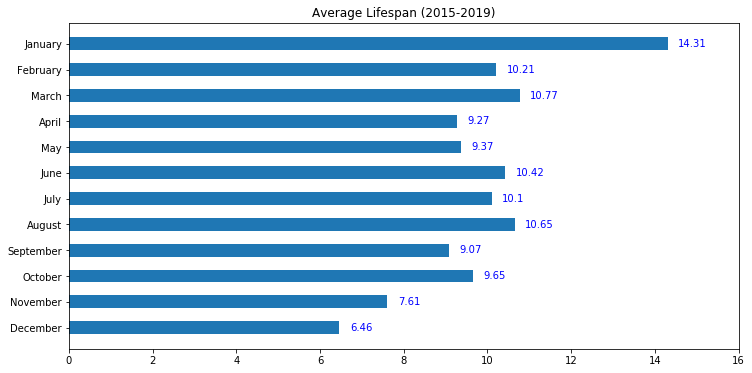

In [204]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, avg_lifespan, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(avg_lifespan):
    ax.text(v + 0.25, i + .1, str(v), color='blue')
ax.set_xlim(0,16)
ax.set_title('Average Lifespan (2015-2019)')

In [194]:
avg_lifespan_per_month = spark.sql('''
            SELECT MONTH(entrance_date) AS month, ROUND(AVG(num_weeks),2) AS avg_lifespan
            FROM test3
            WHERE entrance_date < "2019-11-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''')

In [195]:
avg_lifespan = avg_lifespan_per_month.rdd.map(lambda row: row.avg_lifespan).collect()

In [196]:
avg_lifespan

[14.31, 10.21, 10.77, 9.27, 9.37, 10.42, 10.1, 10.65, 9.07, 9.65, 9.13, 7.64]

Text(0.5, 1.0, 'Average Lifespan (Dec 2019 removed)')

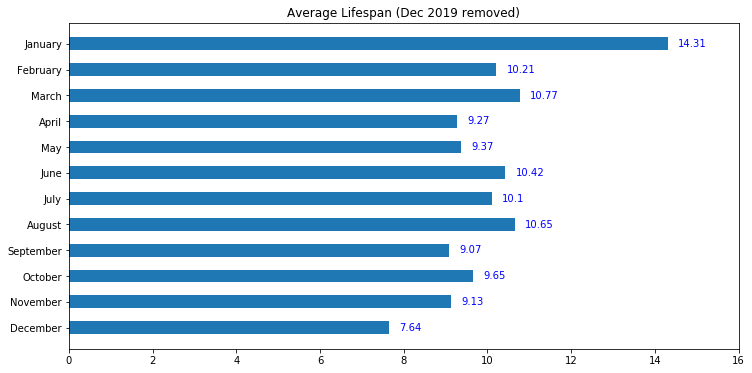

In [198]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, avg_lifespan, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(avg_lifespan):
    ax.text(v + 0.25, i + .1, str(v), color='blue')
ax.set_xlim(0,16)
ax.set_title('Average Lifespan (Dec 2019 removed)')

In [199]:
avg_lifespan_per_month_2 = spark.sql('''
            SELECT MONTH(entrance_date) AS month, ROUND(AVG(num_weeks),2) AS avg_lifespan
            FROM test3
            WHERE entrance_date < "2018-01-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''')

In [200]:
avg_lifespan_2 = avg_lifespan_per_month_2.rdd.map(lambda row: row.avg_lifespan).collect()

Text(0.5, 1.0, 'Average Lifespan (Without songs released in 2019)')

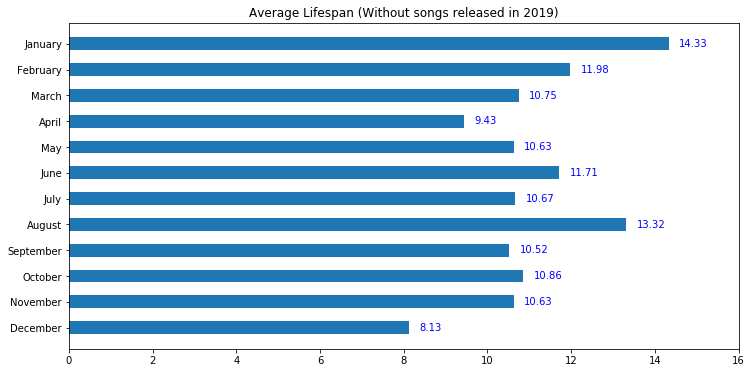

In [201]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, avg_lifespan_2, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(avg_lifespan_2):
    ax.text(v + 0.25, i + .1, str(v), color='blue')
ax.set_xlim(0,16)
ax.set_title('Average Lifespan (Without songs released in 2019)')

In [307]:
survival = spark.sql('''
            SELECT num_weeks, COUNT(*) as count
            FROM test5
            GROUP BY num_weeks
            ''')

In [ ]:
survival.rdd.map(lambda row: row.avg_lifespan).collect()